In [1]:
 
import numpy as np

#Fetching the dataset
import pandas as pd


#import transaction data and the promos data
data_transact = pd.read_csv('transactions.csv',delimiter=',', encoding="utf-8-sig")
data_promo = pd.read_csv('promos.csv',delimiter=',', encoding="utf-8-sig")

#view top 10 rows
data_transact.head(10)


,id,history_date,item_id,price,inventory,sales,category_id
0,103,2014-01-01,394908219,24.97,374.0,NaN,3
1,223,2014-01-01,394942631,106.33,374.0,NaN,3
2,319,2014-01-01,511895631,31.98,374.0,NaN,3
3,427,2014-01-01,512317778,33.21,102.0,NaN,3
4,487,2014-01-01,512319955,117.62,139.0,NaN,3
5,571,2014-01-01,512464656,287.46,235.0,NaN,3
6,18,2014-01-01,394853569,119.04,271.0,NaN,3
7,282,2014-01-01,395334759,30.05,242.0,NaN,3
8,306,2014-01-01,395360835,121.58,0.0,NaN,3
9,402,2014-01-01,512319957,17.44,146.0,138.05,3


In [2]:
data_promo.head(10)

,item_id,promo_type,promo_start_dt,promo_end_dt
0,394848103,PROMO_C,2014-06-24,2014-07-24
1,394848314,PROMO_B,2014-04-03,2014-05-03
2,394859626,PROMO_B,2014-07-23,2014-08-22
3,394862997,PROMO_A,2015-01-09,2015-02-08
4,394867143,PROMO_C,2014-03-19,2014-04-18
5,394867160,PROMO_B,2014-04-14,2014-05-14
6,394868816,PROMO_A,2014-06-28,2014-07-28
7,394881368,PROMO_C,2016-03-21,2016-04-20
8,394883117,PROMO_A,2014-09-30,2014-10-30
9,394889903,PROMO_C,2014-09-16,2014-10-16


In [3]:
train, target = pd.DataFrame(data_transact ), pd.DataFrame(data_promo)



# Imputing missing sales data with 0 value

In [4]:
#Impute the values using scikit-learn SimpleImpute Class
from sklearn.impute import SimpleImputer
imp_zeros = SimpleImputer( missing_values=np.nan , strategy='constant', fill_value=0 ,copy=True)#fill missing values with 0 constant
imp_zeros.fit(train)
imputed_train_df = imp_zeros.transform(train)

In [5]:
imputed_train_df.shape


(400059, 7)

In [6]:
imputed_tr = pd.DataFrame(imputed_train_df, columns=train.columns)
imputed_tr.head(12)

,id,history_date,item_id,price,inventory,sales,category_id
0,103,2014-01-01,394908219,24.97,374,0,3
1,223,2014-01-01,394942631,106.33,374,0,3
2,319,2014-01-01,511895631,31.98,374,0,3
3,427,2014-01-01,512317778,33.21,102,0,3
4,487,2014-01-01,512319955,117.62,139,0,3
5,571,2014-01-01,512464656,287.46,235,0,3
6,18,2014-01-01,394853569,119.04,271,0,3
7,282,2014-01-01,395334759,30.05,242,0,3
8,306,2014-01-01,395360835,121.58,0,0,3
9,402,2014-01-01,512319957,17.44,146,138.05,3


# Negative sales are interpreted as returns and should be subtracted from any aggregations of sales.

In [7]:
print((imputed_tr['sales']<0).sum()) # how much negative sales
imputed_tr= imputed_tr.drop(imputed_tr[imputed_tr.sales<0].index) # drop them from sales (interepted as returns)

2


# Units can be estimated as floor(sales / price)

In [24]:
imputed_tr['Units'] = (imputed_tr['sales']/imputed_tr['price']).astype(int)
imputed_tr.head(15)

,id,history_date,item_id,price,inventory,sales,category_id,Units,Week_Number,Year,Week_Id,revenue
0,103,2014-01-01,394908219,24.97,374,0,3,0,1,2014,1,24.97
1,223,2014-01-01,394942631,106.33,374,0,3,0,1,2014,1,106.33
2,319,2014-01-01,511895631,31.98,374,0,3,0,1,2014,1,31.98
3,427,2014-01-01,512317778,33.21,102,0,3,0,1,2014,1,33.21
4,487,2014-01-01,512319955,117.62,139,0,3,0,1,2014,1,117.62
5,571,2014-01-01,512464656,287.46,235,0,3,0,1,2014,1,287.46
6,18,2014-01-01,394853569,119.04,271,0,3,0,1,2014,1,119.04
7,282,2014-01-01,395334759,30.05,242,0,3,0,1,2014,1,30.05
8,306,2014-01-01,395360835,121.58,0,0,3,0,1,2014,1,121.58
9,402,2014-01-01,512319957,17.44,146,138.05,3,7,1,2014,1,122.08


# Aggregate the data to weekly level, so that there is one row per product-week combination



In [25]:
 #Converting date to pandas datetime format
imputed_tr['history_date'] = pd.to_datetime(imputed_tr['history_date'])

imputed_tr['Week_Number'] = imputed_tr['history_date'].dt.week# Getting week number

# Getting year. Weeknum is common across years to we need to create unique index by using year and weeknum
imputed_tr['Year'] = imputed_tr['history_date'].dt.year

#Creating a combination of WeekOfYear and Year
imputed_tr['Week_Id'] = (imputed_tr['Year'].astype(int)-2014)*53+imputed_tr['Week_Number'].astype(int)

#Calculating income based on unit's price and number of units sold
imputed_tr['revenue'] = imputed_tr['price'] * imputed_tr['Units']

# Grouping based on Week_Id
df2 = imputed_tr[['revenue','Week_Id']].groupby([ 'Week_Id']).sum()
df2.head(10)#visualizing 

,revenue
Week_Id,
1,15229.340
2,15097.605
3,16236.280
4,21274.800
5,17482.820
6,12745.600
7,17296.390
8,16209.150
9,18383.060


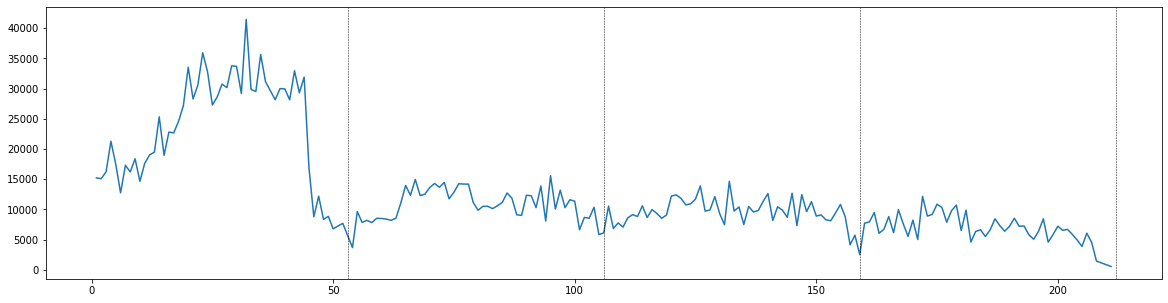

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(df2)
for i in range(4):
    plt.axvline(x=(i+1)*53,color='black',linestyle='--',linewidth=0.5)
plt.show()

# Create any additional features you feel would help in modeling

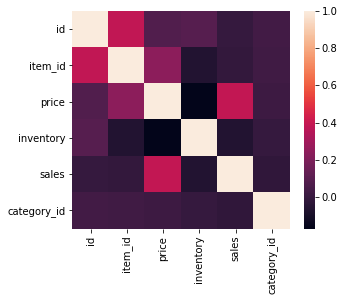

In [15]:
import seaborn as sns
#plot some heatmap to find correlation among the features
corrmat = train.corr();
f , ax = plt.subplots(figsize=(5,4))
sns.heatmap(corrmat, square=True)

Each square in an heatmap shows how much any two feature correlates (is there some kind of relationship between them). 
Does the increase in one feature result in the increase of the other-->(Positive correlation) or does the increase in one result in the decrease of the other -->(Negative correlation).

The vertical range running from 0.0 to 1.0 shows you the relative size of the correlation between any two features, where hotter values are higher and means more correlation.
The diagonal almost-whitish portion of the matrix shows that all features are highly correlated to the themselves.  

Tracing the first label horizontally to the left leads to Week_number and tracing it vertically downwards, leads to Week_Id. This means the square box (3) is showing us how correlated price and Category_Id are. We can see that they’re highly correlated as the color becomes hot pink.
Tracing the second interesting label shows the correlation between Price and  Sales. We clearly see that the region is hot, meaning there’s a high correlation.
 

# we start adding significant features

Price_category: This is the price of each category 
Verdict: Important
This is a concatenation of the price and category identifier.
Reason: Some type of products categorues will generally sell more than others due to the price


Price_sales: 
This is a concatenation of the Price and sales.
Reason: Some type of product will generally sell more than others.
Verdict: Important
Reason: This is certainly an important feature because the price of products will definitely affect out the sales

In [22]:
imputed_tr['Price_Category'] = imputed_tr[['price','category_id']].astype(str).apply('|'.join,1)
imputed_tr.head(10)

,id,history_date,item_id,price,inventory,sales,category_id,Units,Week_Number,Year,Week_Id,revenue,Price_Category
0,103,2014-01-01,394908219,24.97,374,0,3,1,1,2014,1,24.97,24.97|3
1,223,2014-01-01,394942631,106.33,374,0,3,1,1,2014,1,106.33,106.33|3
2,319,2014-01-01,511895631,31.98,374,0,3,1,1,2014,1,31.98,31.98|3
3,427,2014-01-01,512317778,33.21,102,0,3,1,1,2014,1,33.21,33.21|3
4,487,2014-01-01,512319955,117.62,139,0,3,1,1,2014,1,117.62,117.62|3
5,571,2014-01-01,512464656,287.46,235,0,3,1,1,2014,1,287.46,287.46|3
6,18,2014-01-01,394853569,119.04,271,0,3,1,1,2014,1,119.04,119.04|3
7,282,2014-01-01,395334759,30.05,242,0,3,1,1,2014,1,30.05,30.05|3
8,306,2014-01-01,395360835,121.58,0,0,3,1,1,2014,1,121.58,121.58|3
9,402,2014-01-01,512319957,17.44,146,138.05,3,7,1,2014,1,122.08,17.44|3


# Make sure to perform any other transformations for missing values, outliers, improperly scaled information, or anything else that would represent a best practice for data scientists.

In [ ]:
imputed_tr.isnull().sum() # make sure that we haven't any NaN attribute